# Part 1 of the project in CMPE252, Fall 2022, SJSU 
### In this part you will train an artificial agent to solve the Maze task using Q-Learning
### Your can work in teams. The number of points for this part of the project is 33/100.
### Submit in two separate files (not in a single zip) your solution for Part 1 in this notebook and export it to a PDF file. 
### Due: Dec 9, 11:59PM in Canvas.
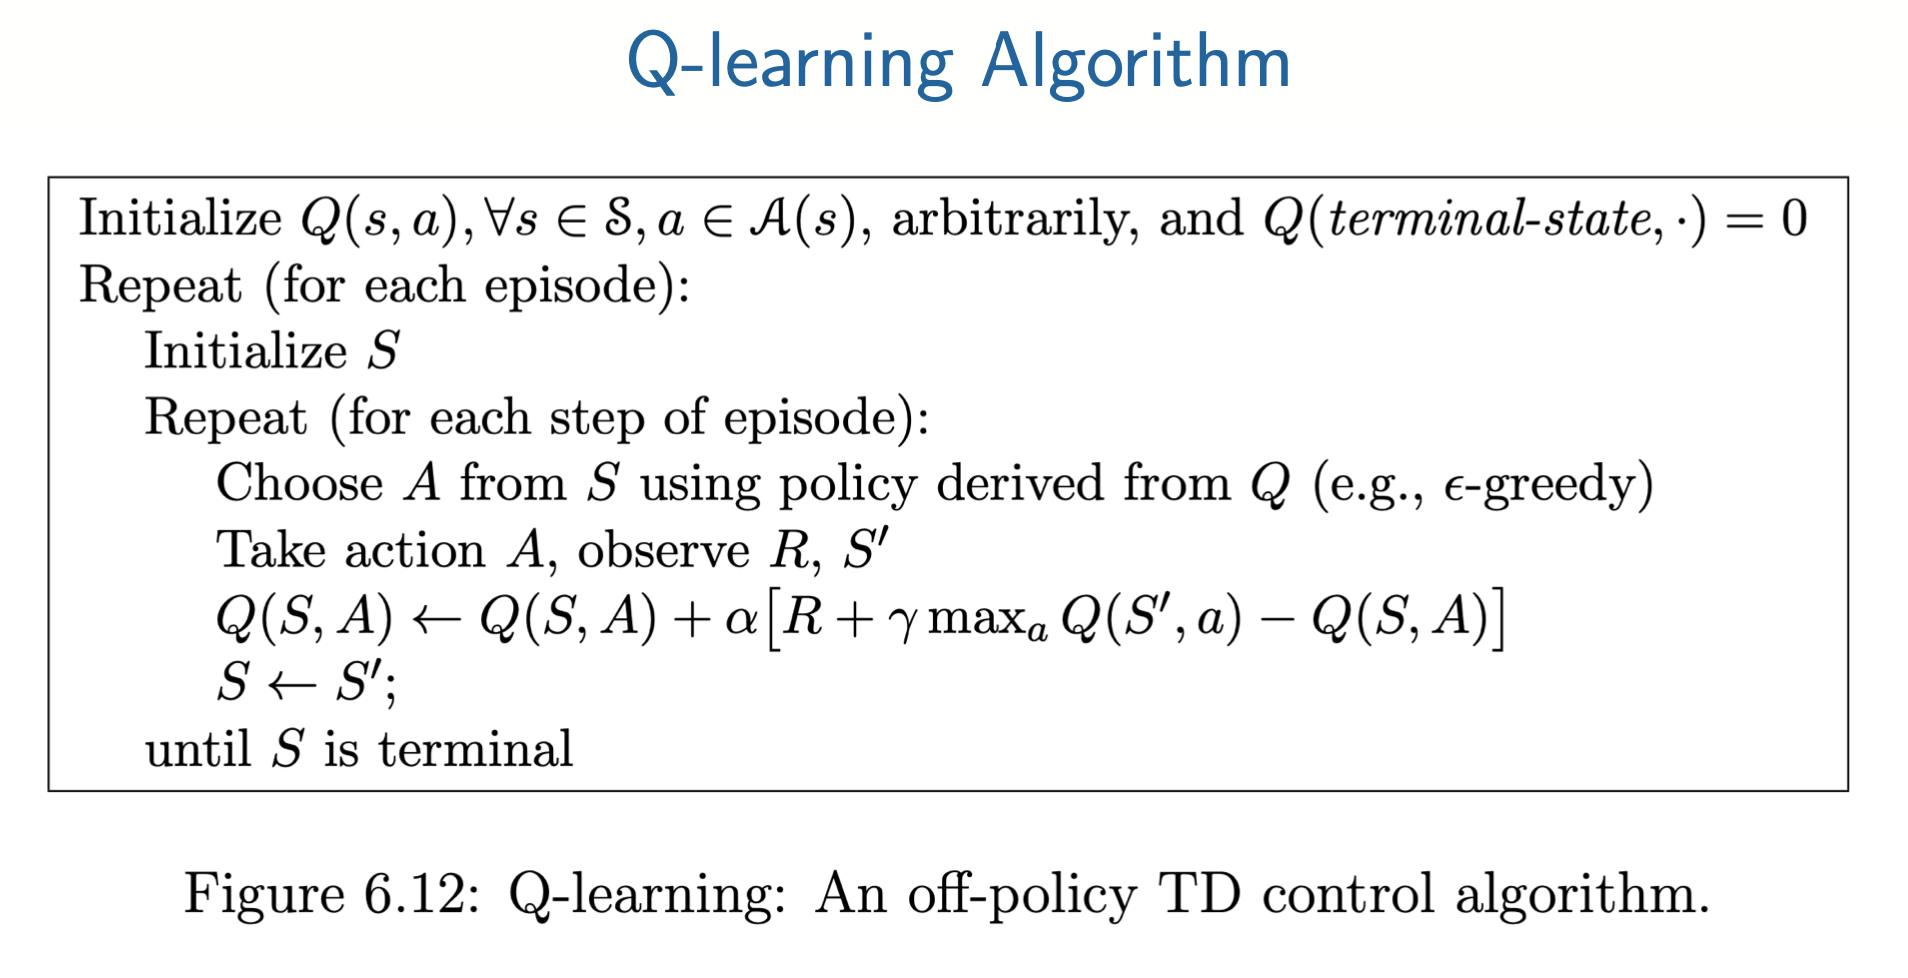

Importing the necessary libraries:

In [2]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
import numpy as np
import random
import copy
%matplotlib inline

Initialize the environment as per the problem statement:

In [3]:


# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise
ALPHA = 0.01

# learning rate
lr = 0.99

A_LIST = ['up', 'down', 'left', 'right', 'stay']
EPSILON = 0.2

EPISODE_LENGTH_MAX = 400

Visualize the maze

(9, 10)

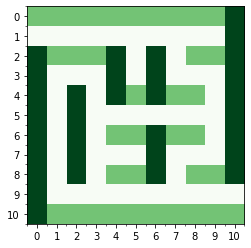

In [4]:
def build_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall in the maze
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    GRID_SIZE=len(m)

    for i in range(GRID_SIZE):
        for j in range(len(m[i])):
            if (i==GRID_SIZE-1 and m[i-1][j]==2) or (i!=GRID_SIZE-1 and (m[i+1][j]==1 or m[i-1][j]==2) and m[i][j]==1):
                m[i][j]=2
    return np.array(m)
S=build_maze("maze_11x11.txt")#upload the same maze used in HW1 or maze which is in same format
plt.imshow(S, cmap="Greens")
GRID_SIZE = len(S)
ax = plt.gca()
ax.set_xticks(np.arange(0, GRID_SIZE, 1))
ax.set_yticks(np.arange(0, GRID_SIZE, 1))
ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)




# rewards
R_GOAL = 0
R_HIT_WALL = -5
R_STEP = -1

START = (1, 0)
GOAL = (GRID_SIZE - 2, GRID_SIZE - 1)
GOAL

State transition dynamics check

In [5]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) or (S[curr]==2 and action==3) or (S[s_new]==1 and action==0) or (S[s_new]==2 and action==2):
        return True

    return False

We assume that the environment assigns rewards using the following reward function. Note that this reward function is not visible to the agent, which can only learn from the observation samples.

In [6]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return R_GOAL
    elif hit_wall(s, a):
        return R_HIT_WALL
    else:
        return R_STEP

We define a utility function s_next_calc, which calculates the next state given current state and action:

In [7]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

The agent will use the following function to stochastically perform an action and obtains the next state and the associated reward.

In [8]:
def step(s, a):
    '''This function stochastically performs the action 'a' on the given
      state s.
     : param s: Current position of the agent
     : param a: Chosen action by the agent
     : returns: New state coordinates in the grid and the reward
      '''
    action_list = [a]
    probs = [1 - ALPHA]
    for action in range(len(A)):
        if action != a:
            action_list.append(action)
            probs.append(ALPHA)

    #print(action_list)
    action_taken = random.choices(action_list, cum_weights=probs)[0]
    r = R(s, action_taken)
    if r == R_HIT_WALL or R_GOAL: # can't move
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r

We will use the following function to choose an action for the state from Q using a basic epsilon-greedy implementation:

In [9]:
def choose_action_epsilon(Q, s, epsilon):
    """return a string action"""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(A)-1)
    return np.argmax(Q[s[0], s[1], :])

The agent uses the following function for Q-Learning:

In [10]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, GRID_SIZE, 1))
    ax.set_yticks(np.arange(0, GRID_SIZE, 1))
    ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1] - 0.5*quiver_action_dict[v][1], k[0] + 0.5 * quiver_action_dict[v][0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

In [11]:
def q_learning(gamma, episodes, lr, EPSILON, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param episodes: Number of episodes to be run
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        if episode<70:
            s = (np.random.randint(0, GRID_SIZE), np.random.randint(0, GRID_SIZE))
        else:
            s=START
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Choose a random action for the current state s
            a = choose_action_epsilon(Q, s, EPSILON)
            # Take the random action with a transition error ALPHA
            s_next, r = step(s, a)
            # print(s_next, r, s, a)
            # finding the next max qvalue for the next state
            max_q_next = np.max(Q[s_next])
            # print(s, a, s_next, r)
            # Update Q table
            Q[s[0]][s[1]][a] =  (1 - lr) * Q[s[0]][s[1]][a] + lr * (r + gamma * max_q_next)
            #update current state with next state
            s =  s_next
            #add the current reward with accumulated reward
            r_sum = lr * r + r_sum
            #increment the Episode count by one
            i = i+1
            
        
        #increment the sum_step with the Episode count

        sum_steps = 'complete code'
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return r_list

Run the Q-learning algorithm:

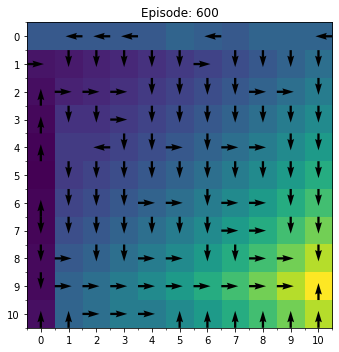

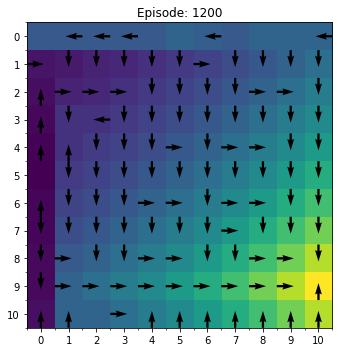

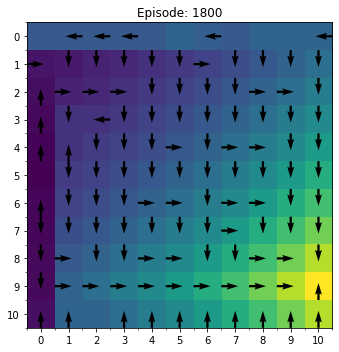

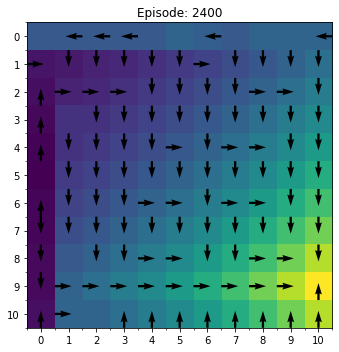

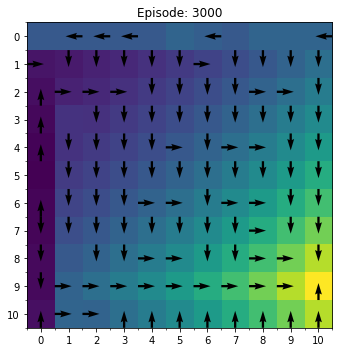

In [30]:
eps = 3000 #epochs
gamma=0.9 #discounting factor
r_list = q_learning(gamma , eps, lr, EPSILON)

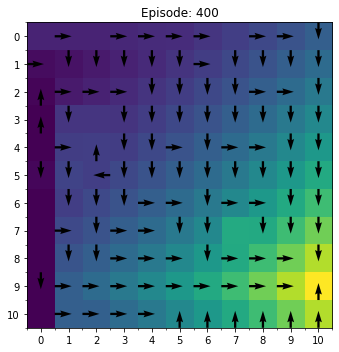

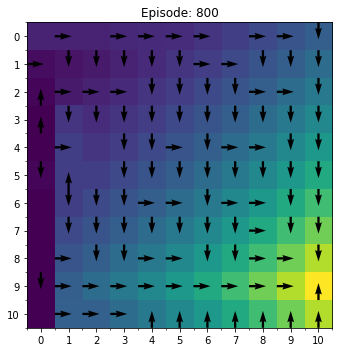

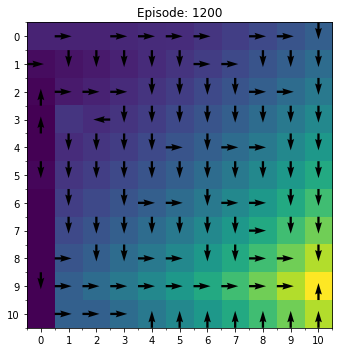

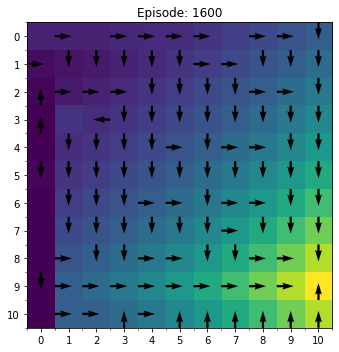

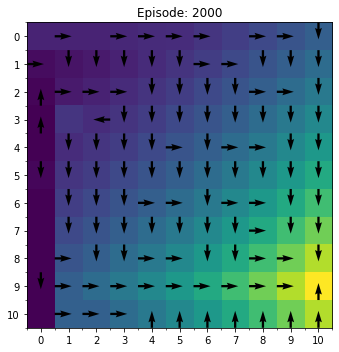

In [32]:
steps = 2000
numberOfSeeds=5
a_rewards=[]
for i in range(numberOfSeeds):
    a_rewards.append(q_learning(gamma, steps, lr,EPSILON, show=True))
a_rewards=np.array(a_rewards)
a_rewards_avg=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)

Text(0.5, 0, 'Episodes')

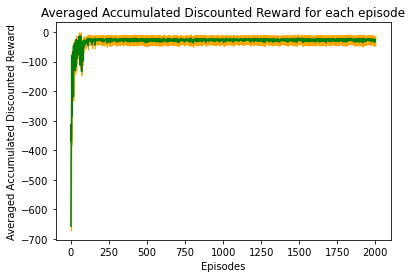

In [33]:
a=a_rewards_avg+0.5*sd
b=a_rewards_avg-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards_avg, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode")
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

- Explain the learing curve above. Why does it increase? What does the steady state value (flat) mean? Why is there a variance between different seeds? 

The agent goes around the environment without following a particular policy. It chooses an optimal policy using the knowledge it gained by going around the environment randomly. So, the rewards tends to increase in the beginning, while stabilising to a steady value as the episodes pass by. This means that agent has now found an optimal policy that gives it optimum rewards. This explains the steadiness in the average accumulated rewards. As the agent gains more knowledge of the environment, its behaviour also changes and the policy it follows also changes with time. This is why we can observe the variance between different seeds.

## Task 1

**Run "q_learning" and plot the accumulated reward as a function of epoch for the gamma values in(0.8, 0.2)**

0
1
2
3
4


Text(0.5, 0, 'Episodes')

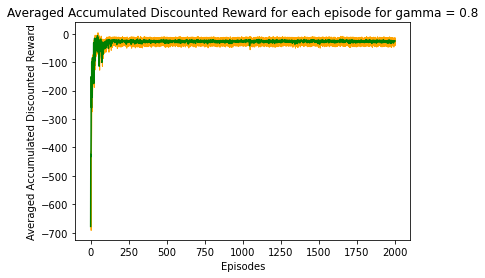

In [35]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  print(i)
  a_rewards.append(q_learning(0.8, steps, 0.99,EPSILON, show=False))
a_rewards=np.array(a_rewards)
a_rewards_avg=np.average(a_rewards, axis=0)
sd=np.std(a_rewards_avg)
a=a_rewards_avg+0.5*sd
b=a_rewards_avg-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards_avg, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

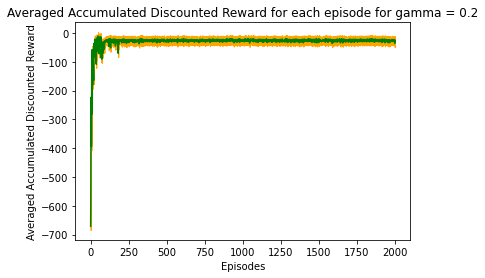

In [36]:
steps = 2000
numberOfSeeds=5
a_rewards=[]
for i in range(numberOfSeeds):
    a_rewards.append(q_learning(0.2, steps, 0.99,EPSILON, show=False))
a_rewards=np.array(a_rewards)
a_rewards_avg=np.average(a_rewards, axis=0)
sd=np.std(a_rewards_avg)
a=a_rewards_avg+0.5*sd
b=a_rewards_avg-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards_avg, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.2))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 2

**Run the q_learning function with adding noise to Q learning function**

Text(0.5, 0, 'Episodes')

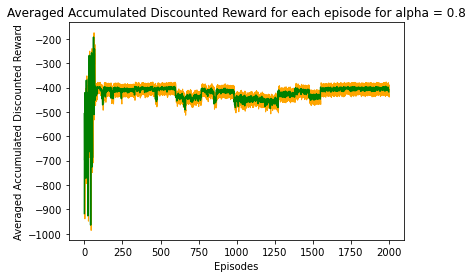

In [13]:
ALPHA = 0.8   #adding noise of 0.8

steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99, 0, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 3

**Run "q_learning" and plot the accumulated reward as a function of epoch for the learning rate values in (0, 0.5, 1)**

Text(0.5, 0, 'Episodes')

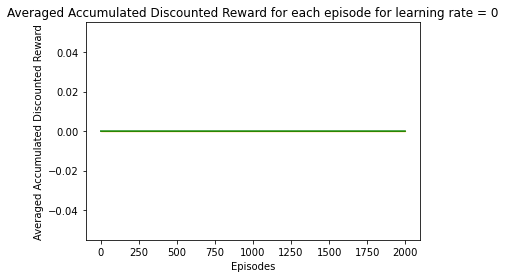

In [37]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0,EPSILON, show=False))
a_rewards=np.array(a_rewards)
a_rewards_avg=np.average(a_rewards, axis=0)
sd=np.std(a_rewards_avg)
a=a_rewards_avg+0.5*sd
b=a_rewards_avg-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards_avg, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for learning rate = " + str(0))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

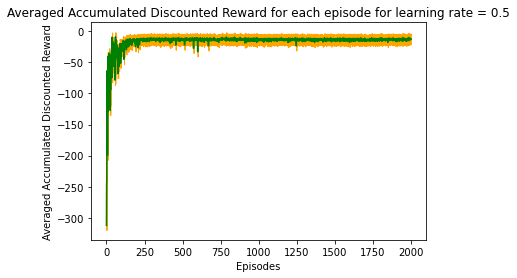

In [38]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.5,EPSILON, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for learning rate = " + str(0.5))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

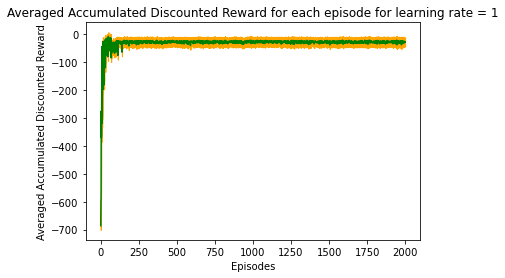

In [39]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 1,EPSILON, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for learning rate = " + str(1))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 4

**Run "q_learning" and plot the accumulated reward as a function of epoch for the epsilon in (0, 0.5, 1)**

Text(0.5, 0, 'Episodes')

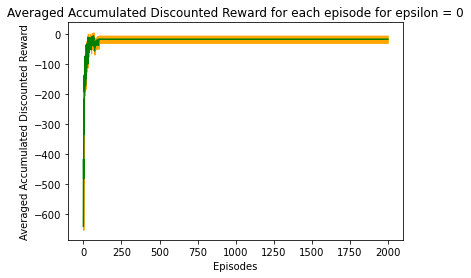

In [40]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for epsilon = " + str(0))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

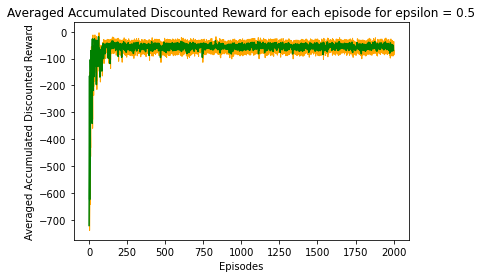

In [41]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0.5, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for epsilon = " + str(0.5))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

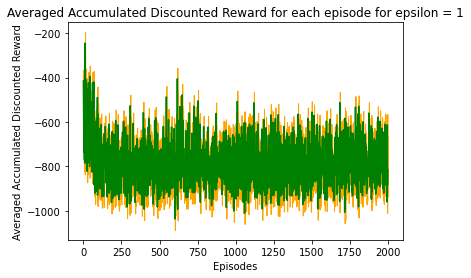

In [42]:
steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 1, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for epsilon = " + str(1))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 5

**Run "q_learning" and plot the accumulated reward as a function of epoch for the alpha values in (0.8, 0.09)**

Text(0.5, 0, 'Episodes')

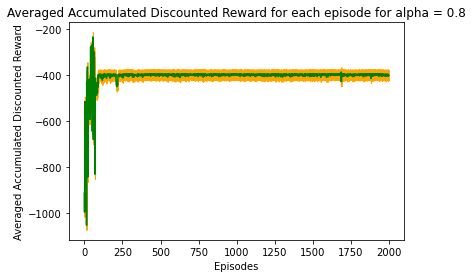

In [43]:
ALPHA = 0.8

steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

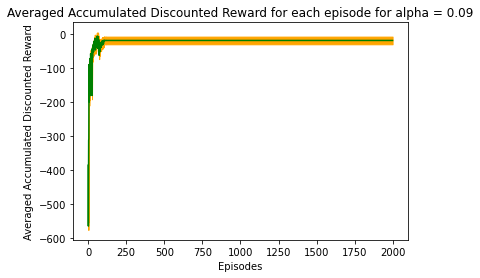

In [44]:
ALPHA = 0.09

steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.09))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

**Observations**

- Explain briefly how the results change for different values of 'gamma'

Gamma is the discounting factor. Higher gamma values means later rewards are given as importance as the immediate rewards. Lower gamma means immediate rewards are given more priority than the later rewards. In the program, we can see that as the episode count increases, higher gamma tend to give us slightly better rewards than lower gamma. But as the number of episodes grows and as the program learns more about the maze, both gamma values tend to give us almost similar results, with 0.8 gamma giving us slightly better results compared to 0.2 gamma.

- Explain briefly how the results change for different values of 'learning rate'

Learning rate 0 gives us no accumulated rewards. Learning rate 0.5 tends to give us more rewards in the initial episodes as compared to learning rate 1. But as the number of episodes increase, both the learning rates tend to give us more or less the same rewards. Decay in learning rate is most recommended because, we have to take giant strides towards solution initially, but as we approach the solution, we have to take smaller steps. So, adding the decay factor would help us in maneuvering the learning rate. 

- Explain briefly how the results change for different values of 'alpha'

Alpha is the noise or uncertainity in the action. Higher alpha gives us less rewards. In the program above, we can see that for alpha=0.8, the average reward stood at -400 for nearly the entire length of episodes. While lower alpha=0.09 gave us better rewards averaging at near zero. 

- Explain briefly how the results change for different values of 'epsilon'

Epsilon is the exploration-exploitation tradeoff in Q learning. It determines how the system should balance exploration and exploitation. Higher the value of epsilon, more are the chances of exploration. In the program, 0 epsilon values means that the system has no chance to explore and that it sticks to the greedy method of accumunating rewards, thus giving us minimal results. As the epsilon value grows to 0.5 and then to 1, our rewards also increase. 

**Insights**

- Explain the meaning of alpha and gamma

Alpha is the noise or uncertainity in the action. Gamma is the discounting factor that trades-off between immediate results and the results that we get in later actions. Higher gamma takes later rewards into consideration 'better' than lower gamma. 

- Explain briefly the 'Exploration vs. Exploitation Trade-off'


Exploration-Exploitation tradeoff tells the system when to explore and when to exploit. Initially when the system doesn't have much knowledge about the environment, it tends to explore. But with time, it begins to exploit using greedy method for better immediate rewards and gradually stops exploring. It is then that this trade-off helps the system to continue exploring the environment, while continuing to exploit the known states using greedy method. It is denoted using epsilon. Higher epsilon, more are the chances of exploration, and more are the chances of rewards(atleast that is what we can hope so). 

- Explain briefly the meaining of on-policy and off-policy algorithms

On-policy algorithms means the agent follows a particular policy and tries to extract maximum rewards from the states using that policy. Off-policy means the agent goes around the environment without a fixed policy, explores on its own and behave randomly, while still arriving at optimal policy on its own. 

**Submission Requirements**
- The submission for this part should contain a executed .ipynb file, pdf of the executed .ipynb file and the maze file which been used for your execution.

**Plotting Requirements**
- please check that all the plots titles, axes labels, legends are in large/readable fonts.

All the plots, titles, axes labels and legends are in large/readable fonts. 